# Image Synthesis using Generative Adversarial Networks
### By Siddheswar Chandrasekhar

In [1]:
import keras
import tensorflow as tf
import numpy as np
import time
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm
from skimage.transform import resize
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm

from keras.callbacks import TensorBoard

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

try:
    from google.colab import files
except:
    print("Couldn't import Google Colab")

Using TensorFlow backend.


#### load cifar10

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


### FID class

In [0]:
class FID:
    def __init__(self):
        self.model = InceptionV3(
            include_top=False, pooling='avg', input_shape=(299, 299, 3)
        )

    @staticmethod
    def scale_images(images, new_shape):
        images_list = list()
        for image in images:
            new_image = resize(image, new_shape, 0)  # Resize with nearest neighbor interpolation
            images_list.append(new_image)
        return np.asarray(images_list)

    def calculate(self, images1, images2, preprocess=False):
        # Convert integer to floating point values
        images1 = images1.astype('float32')
        images2 = images2.astype('float32')

        # Resize images
        images1 = self.scale_images(images1, new_shape=(299, 299, 3))
        images2 = self.scale_images(images2, new_shape=(299, 299, 3))

        if preprocess:
            # Pre-process images
            images1 = preprocess_input(images1)
            images2 = preprocess_input(images2)

        # Calculate activations
        act1 = self.model.predict(images1)
        act2 = self.model.predict(images2)

        # Calculate mean and covariance statistics
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

        # Calculate Sum of Squared Differences between means
        ssdiff = np.sum((mu1 - mu2) ** 2.0)

        # Calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))

        # Check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real

        # Calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

### DCGAN class

In [0]:
class DCGAN:

    def __init__(self, dataset, kernel_size, strides, padding='same',
                 latent_dim=100, w_init=keras.initializers.RandomNormal(stddev=0.02), lrelu_slope=0.2):
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.latent_dim = latent_dim
        self.w_init = w_init
        self.lrelu_slope = lrelu_slope
        self.generator = keras.models.Sequential()
        self.discriminator = keras.models.Sequential()
        (self.x_train, self.y_train), (self.x_test, self.y_test) = dataset

        self.test = keras.layers.Concatenate()([keras.layers.Input(shape=(100,)), keras.layers.Input(shape=(10,))])
    
    def _test(self):
        print(self.test)
        print(type(self.test))
        print(self.test.shape)

    def _generator(self, activation='tanh'):
        # Since we use tanh activation, we clip the image data into the range between -1 and 1
        self.x_train = np.float32(self.x_train)
        self.x_train = (self.x_train / 255 - 0.5) * 2
        self.x_train = np.clip(self.x_train, -1, 1)

        self.x_test = np.float32(self.x_test)
        self.x_test = (self.x_test / 255 - 0.5) * 2
        self.x_test = np.clip(self.x_test, -1, 1)

        # 2x2x512
        self.generator.add(keras.layers.Dense(2*2*512, input_shape=(self.latent_dim,), kernel_initializer=self.w_init))
        self.generator.add(keras.layers.Reshape((2, 2, 512)))
        self.generator.add(keras.layers.BatchNormalization())
        self.generator.add(keras.layers.LeakyReLU(self.lrelu_slope))

        # 4x4x256
        self.generator.add(keras.layers.Conv2DTranspose(
            256, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)
        )
        self.generator.add(keras.layers.BatchNormalization())
        self.generator.add(keras.layers.LeakyReLU(self.lrelu_slope))

        # 8x8x128
        self.generator.add(keras.layers.Conv2DTranspose(
            128, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)
        )
        self.generator.add(keras.layers.BatchNormalization())
        self.generator.add(keras.layers.LeakyReLU(self.lrelu_slope))

        # 16x16x64
        self.generator.add(keras.layers.Conv2DTranspose(
            64, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)
        )
        self.generator.add(keras.layers.BatchNormalization())
        self.generator.add(keras.layers.LeakyReLU(self.lrelu_slope))
        
        # 32x32x3
        self.generator.add(keras.layers.Conv2DTranspose(
            3, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, activation=activation)
        )

        print(self.generator.summary())

    def _discriminator(self, activation='sigmoid'):
        # 16x16x64
        self.discriminator.add(keras.layers.Conv2D(
            64,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            input_shape=self.x_train[0].shape,
            kernel_initializer=self.w_init)
        )
        self.discriminator.add(keras.layers.LeakyReLU(self.lrelu_slope))

        # 8x8x128
        self.discriminator.add(keras.layers.Conv2D(
            128, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)
        )
        self.discriminator.add(keras.layers.BatchNormalization())
        self.discriminator.add(keras.layers.LeakyReLU(self.lrelu_slope))

        # 4x4x256
        self.discriminator.add(keras.layers.Conv2D(
            256, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)
        )
        self.discriminator.add(keras.layers.BatchNormalization())
        self.discriminator.add(keras.layers.LeakyReLU(self.lrelu_slope))

        # 2x2x512
        self.discriminator.add(keras.layers.Conv2D(
            512, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding)
        )
        self.discriminator.add(keras.layers.BatchNormalization())
        self.discriminator.add(keras.layers.LeakyReLU(self.lrelu_slope))

        self.discriminator.add(keras.layers.Flatten())
        self.discriminator.add(keras.layers.Dense(1, activation=activation))

        print(self.discriminator.summary())

    def _compile(self, optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.5)):
        self._generator()
        self._discriminator()

        self.discriminator.compile(optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
        self.discriminator.trainable = False
        z = keras.layers.Input(shape=(self.latent_dim,))
        img = self.generator(z)
        decision = self.discriminator(img)
        self.dg = keras.models.Model(inputs=z, outputs=decision)
        self.dg.compile(optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

    def _fit(self, epochs, batch_size, learning_rate, fid_evaluation=False):
        if fid_evaluation:
            fid = FID()
            fid_score = list()
        generator_loss = list()
        discriminator_loss = list()
        fake_samples = np.zeros(shape=(batch_size, 1))
        real_samples = np.ones(shape=(batch_size, 1))

        for epoch in tqdm(range(epochs), total=epochs):
            discriminator_batch_losses = list()
            generator_batch_losses = list()
            for batch in range(len(self.x_train) // batch_size):
                self.discriminator.trainable = True

                # Real sampling
                x_batch = self.x_train[batch*batch_size:(batch+1)*batch_size]
                discriminator_loss_real = self.discriminator.train_on_batch(x=x_batch, y=real_samples*(1-learning_rate))

                # Fake sampling
                z = np.random.normal(loc=0, scale=1, size=(batch_size, self.latent_dim))
                x_fake = self.generator.predict_on_batch(z)
                discriminator_loss_fake = self.discriminator.train_on_batch(x=x_fake, y=fake_samples)

                # Discriminator Loss
                # discriminator_loss_batch = 0.5 * (discriminator_loss_real[0] + discriminator_loss_fake[0])
                discriminator_batch_losses.append(0.5 * (discriminator_loss_real[0] + discriminator_loss_fake[0]))

                # Train Generator weights
                self.discriminator.trainable = False
                generator_batch = self.dg.train_on_batch(x=z, y=real_samples)
                generator_batch_losses.append(generator_batch[0])

                if (batch == (len(self.x_train) // batch_size) - 1) and fid_evaluation:
                    fid_z = np.random.normal(loc=0, scale=1, size=(1000, self.latent_dim))
                    fid_x_fake = self.generator.predict(fid_z)
                    # score = fid.calculate(self.x_test, fid_x_fake)
                    p = np.random.permutation(range(len(self.x_test)))
                    score = fid.calculate(self.x_test[p[:1000]], fid_x_fake)
                    print("FID score: " + str(score))
                    fid_score.append(score)

            discriminator_loss.append(discriminator_batch_losses[-1])
            generator_loss.append(generator_batch_losses[-1])

            print('epoch=%d, discriminator_loss=%.3f, generator_loss=%.3f' %
                  ((epoch+1), discriminator_loss[-1], generator_loss[-1]))
            
            if (epoch+1) % 10 == 0:
                samples = 64
                x_fake = self.generator.predict(np.random.normal(loc=0, scale=1, size=(samples, self.latent_dim)))
                plt.clf()
                f = plt.figure(figsize=(10,10))
                for i in range(samples):
                    ax = f.add_subplot(8, 8, i+1, xticks=[], yticks=[])
                    ax.imshow(((x_fake[i]+1)*127).astype(np.uint8))
                f.tight_layout()
                plt.savefig("DCGAN - Epoch" + str(epoch+1) + ".png")
                # plt.show()

            if (epoch+1) % 20 == 0:
                # Loss graph
                plt.clf()
                plt.plot(discriminator_loss)
                plt.plot(generator_loss)
                plt.title('Model loss')
                plt.ylabel('Loss')
                plt.xlabel('Epoch')
                plt.legend(['Discriminator', 'Adversarial'], loc='center right')
                plt.savefig("DCGAN Loss graph - Epoch" + str(epoch + 1) + ".png")
                # plt.show()

                # FID score graph
                plt.clf()
                plt.title('FID score')
                plt.ylabel('Score')
                plt.xlabel('Epoch')
                plt.plot(fid_score)
                plt.savefig("DCGAN FID score graph - Epoch" + str(epoch + 1) + ".png")
                # plt.show()

                !rm -rf dcgan_generator.h5
                !rm -rf dcgan_discriminator.h5
                !rm -rf dcgan.h5
                self.generator.save("dcgan_generator.h5")
                self.discriminator.save("dcgan_discriminator.h5")
                self.dg.save("dcgan.h5")
                !rm -rf cse676proj1.zip
                !zip -r /content/cse676proj1.zip .

In [5]:
dcgan = DCGAN(((x_train, y_train), (x_test, y_test)), kernel_size=5, strides=2, w_init=keras.initializers.RandomNormal(stddev=0.02))

#### Compile and fit the model

In [6]:
dcgan._compile()











Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 25

In [0]:
dcgan._fit(epochs=100, batch_size=64, learning_rate=0.1, fid_evaluation=True)

### Unconditional SAGAN

In [0]:
class SAGAN2:
    def __init__(self, dataset):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = dataset
        self.x_train = np.float32(self.x_train)
        self.x_train = (self.x_train / 255 - 0.5) * 2
        self.x_train = np.clip(self.x_train, -1, 1)

        self.x_test = np.float32(self.x_test)
        self.x_test = (self.x_test / 255 - 0.5) * 2
        self.x_test = np.clip(self.x_test, -1, 1)

        self.y_train = self.one_hot_encode(self.y_train)

    @staticmethod
    def _conv(x, channels):
        filter_size = 4
        input_channels = channels
        output_filters = channels
        filter_ = tf.Variable(tf.truncated_normal(
            [filter_size, filter_size, input_channels, output_filters], stddev=0.5)
        )
        x = tf.nn.conv2d(x, filters=filter_, strides=[1, 1, 1, 1], padding='SAME')
        return x

    @staticmethod
    def _attention(q, k, v, mask=None):
        dot_product = tf.matmul(q, k, transpose_b=True)  # [B, H, N, N]
        if mask:
            dot_product *= mask
        w = tf.nn.softmax(dot_product)  # [B, H, N, N]
        x = tf.matmul(w, v)  # [B, H, N, V]
        return x

    def _self_attention(self, x, key_size=None, down_sample=False):
        if not x.shape.as_list()[1]:
            return x

        H, W, C = x.shape.as_list()[1:]
        if key_size is None:
            key_size = C // 8

        f = self._conv(x, key_size)
        g = self._conv(x, key_size)
        h = self._conv(x, C)

        f_len = gh_len = H * W

        if down_sample:
            g = tf.layers.max_pooling2d(g, 2, 2)
            h = tf.layers.max_pooling2d(h, 2, 2)
            gh_len = H * W // 4

        f = tf.reshape(f, [-1, f_len, key_size])
        g = tf.reshape(g, [-1, gh_len, key_size])
        h = tf.reshape(h, [-1, gh_len, C])

        o = self._attention(f, g, h)
        o = tf.reshape(o, [-1, H, W, C])
        o = self._conv(o, C)

        with tf.variable_scope("gamma", reuse=tf.AUTO_REUSE):
            gamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

        x = gamma * o + x

        return x

    def _generator(self, input_layer, condition_layer,
                   kernel_size=5, strides=2, padding='same', lrelu_slope=0.2, activation='tanh'):
        merged_input = keras.layers.Concatenate()([input_layer, condition_layer])
        hidden_layer = keras.layers.Dense(2 * 2 * 512)(merged_input)
        hidden_layer = keras.layers.Reshape((2, 2, 512))(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization()(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = keras.layers.Conv2DTranspose(
            256, kernel_size=kernel_size, strides=strides, padding=padding)(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization()(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = keras.layers.Conv2DTranspose(
            128, kernel_size=kernel_size, strides=strides, padding=padding)(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization()(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = keras.layers.Conv2DTranspose(
            64, kernel_size=kernel_size, strides=strides, padding=padding)(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization()(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)
        hidden_layer = keras.layers.Lambda(self._self_attention)(hidden_layer)

        hidden_layer = keras.layers.Conv2DTranspose(
            3, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization()(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        model = keras.models.Model(inputs=[input_layer, condition_layer], outputs=hidden_layer)
        print(model.summary())

        return model

    def _discriminator(self, input_layer, condition_layer,
                       kernel_size=5, strides=2, padding='same', lrelu_slope=0.2, activation='sigmoid'):
        hidden_layer = keras.layers.Conv2D(
            64, kernel_size=kernel_size, strides=strides, padding=padding)(input_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)
        hidden_layer = keras.layers.Lambda(self._self_attention)(hidden_layer)

        hidden_layer = keras.layers.Conv2D(
            128, kernel_size=kernel_size, strides=strides, padding=padding
        )(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization()(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = keras.layers.Conv2D(
            256, kernel_size=kernel_size, strides=strides, padding=padding
        )(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization()(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = keras.layers.Conv2D(
            512, kernel_size=kernel_size, strides=strides, padding=padding
        )(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization()(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = keras.layers.Flatten()(hidden_layer)

        merged_output = keras.layers.Concatenate()([hidden_layer, condition_layer])

        hidden_layer = keras.layers.Dense(1, activation=activation)(merged_output)

        model = keras.models.Model(inputs=[input_layer, condition_layer], outputs=hidden_layer)
        print(model.summary())

        return model

    @staticmethod
    def one_hot_encode(y):
        z = np.zeros((len(y), 10))
        idx = np.arange(len(y))
        z[idx, y] = 1
        return z

    @staticmethod
    def generate_noise(n_samples, noise_dim):
        X = np.random.normal(0, 1, size=(n_samples, noise_dim))
        return X

    def generate_random_labels(self, n):
        y = np.random.choice(10, n)
        y = self.one_hot_encode(y)
        return y

    def _compile(self, optimizer, loss, metrics):
        img_input = keras.layers.Input(shape=(32, 32, 3))
        disc_condition_input = keras.layers.Input(shape=(10,))

        self.discriminator = self._discriminator(img_input, disc_condition_input)
        self.discriminator.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        noise_input = keras.layers.Input(shape=(100,))
        gen_condition_input = keras.layers.Input(shape=(10,))

        self.generator = self._generator(noise_input, gen_condition_input)

        gan_input = keras.layers.Input(shape=(100,))
        x = self.generator([gan_input, gen_condition_input])
        gan_out = self.discriminator([x, disc_condition_input])
        self.gan = keras.models.Model(inputs=[gan_input, gen_condition_input, disc_condition_input], output=gan_out)

        print(self.gan.summary())

        self.gan.compile(optimizer=optimizer, loss=loss)

    def _fit(self, epochs, batch_size, learning_rate):
        discriminator_loss = list()
        generator_loss = list()

        real_labels = np.ones(shape=(batch_size, 1))
        generated_labels = np.zeros(shape=(batch_size, 1))

        for epoch in tqdm(range(epochs), total=epochs):
            discriminator_batch_losses = list()
            generator_batch_losses = list()
            for batch in range(len(self.x_train) // batch_size):
                self.discriminator.trainable = True

                x_real = self.x_train[batch*batch_size:(batch+1)*batch_size]
                y_real = self.y_train[batch*batch_size:(batch+1)*batch_size]

                noise_data = self.generate_noise(batch_size, 100)
                random_labels = self.generate_random_labels(batch_size)

                generated_images = self.generator.predict([noise_data, y_real])

                discriminator_loss_real = self.discriminator.train_on_batch(
                    [x_real, y_real], real_labels * (1-learning_rate)
                )
                discriminator_loss_generated = self.discriminator.train_on_batch(
                    [generated_images, y_real], generated_labels * (1-learning_rate)
                )

                discriminator_batch_losses.append(0.5 * (discriminator_loss_real[0] + discriminator_loss_generated[0]))

                self.discriminator.trainable = False

                generator_batch_losses.append(self.gan.train_on_batch([noise_data, random_labels, random_labels], generated_labels)[0])

            discriminator_loss.append(discriminator_batch_losses[-1])
            generator_loss.append(generator_batch_losses[-1])

            print('epoch=%f, discriminator_loss=%.3f, generator_loss=%.3f' %
                  ((epoch+1), discriminator_loss[-1], generator_loss[-1]))

In [0]:
sagan = SAGAN(((x_train, y_train), (x_test, y_test)), kernel_size=5, strides=2, w_init=keras.initializers.RandomNormal(stddev=0.02))

In [0]:
sagan._compile()

In [0]:
sagan._fit(epochs=1000, batch_size=64, learning_rate=0.1, fid_evaluation=True)

### Spectral Normalization

In [0]:
class ConvSN2D(keras.layers.Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=keras.initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)

        # Set input spec.
        self.input_spec = keras.engine.InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (keras.backend.sum(v ** 2) ** 0.5 + eps)

        def power_iteration(W, u):
            # Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(keras.backend.dot(_u, keras.backend.transpose(W)))
            _u = _l2normalize(keras.backend.dot(_v, W))
            return _u, _v

        # Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        # Flatten the Tensor
        W_reshaped = keras.backend.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calculate Sigma
        sigma = keras.backend.dot(_v, W_reshaped)
        sigma = keras.backend.dot(sigma, keras.backend.transpose(_u))
        # normalize it
        W_bar = W_reshaped / sigma
        # reshape weight tensor
        if training in {0, False}:
            W_bar = keras.backend.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = keras.backend.reshape(W_bar, W_shape)

        outputs = keras.backend.conv2d(
            inputs,
            W_bar,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = keras.backend.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs


class ConvSN2DTranspose(keras.layers.Conv2DTranspose):

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (self.filters, input_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=keras.initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)

        # Set input spec.
        self.input_spec = keras.engine.InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        input_shape = keras.backend.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = keras.utils.conv_utils.deconv_length(height, stride_h, kernel_h, self.padding, out_pad_h)
        out_width = keras.utils.conv_utils.deconv_length(width, stride_w, kernel_w, self.padding, out_pad_w)

        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        # Spectral Normalization
        def _l2normalize(v, eps=1e-12):
            return v / (keras.backend.sum(v * 2) * 0.5 + eps)

        def power_iteration(W, u):
            # Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(keras.backend.dot(_u, keras.backend.transpose(W)))
            _u = _l2normalize(keras.backend.dot(_v, W))
            return _u, _v

        W_shape = self.kernel.shape.as_list()
        # Flatten the Tensor
        W_reshaped = keras.backend.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        # Calculate Sigma
        sigma = keras.backend.dot(_v, W_reshaped)
        sigma = keras.backend.dot(sigma, keras.backend.transpose(_u))
        # normalize it
        W_bar = W_reshaped / sigma
        # reshape weight tensor
        if keras.engine.training in {0, False}:
            W_bar = keras.backend.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = keras.backend.reshape(W_bar, W_shape)
        self.kernel = W_bar

        outputs = keras.backend.conv2d_transpose(
            inputs,
            self.kernel,
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format)

        if self.use_bias:
            outputs = keras.backend.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

### Conditional SAGAN

In [0]:
class CSAGAN:
    def __init__(self, dataset):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = dataset
        self.x_train = np.float32(self.x_train)
        self.x_train = (self.x_train / 255 - 0.5) * 2
        self.x_train = np.clip(self.x_train, -1, 1)

        self.x_test = np.float32(self.x_test)
        self.x_test = (self.x_test / 255 - 0.5) * 2
        self.x_test = np.clip(self.x_test, -1, 1)

        self.y_train = self.one_hot_encode(self.y_train)

    @staticmethod
    def _conv(x, channels):
        filter_size = 4
        input_channels = channels
        output_filters = channels
        filter_ = tf.Variable(tf.truncated_normal(
            [filter_size, filter_size, input_channels, output_filters], stddev=0.5)
        )
        x = tf.nn.conv2d(x, filters=filter_, strides=[1, 1, 1, 1], padding='SAME')
        return x

    @staticmethod
    def _attention(q, k, v, mask=None):
        dot_product = tf.matmul(q, k, transpose_b=True)  # [B, H, N, N]
        if mask:
            dot_product *= mask
        w = tf.nn.softmax(dot_product)  # [B, H, N, N]
        x = tf.matmul(w, v)  # [B, H, N, V]
        return x

    def _self_attention(self, x, key_size=None, down_sample=False):
        if not x.shape.as_list()[1]:
            return x

        H, W, C = x.shape.as_list()[1:]
        if key_size is None:
            key_size = C // 8

        f = self._conv(x, key_size)
        g = self._conv(x, key_size)
        h = self._conv(x, C)

        f_len = gh_len = H * W

        if down_sample:
            g = tf.layers.max_pooling2d(g, 2, 2)
            h = tf.layers.max_pooling2d(h, 2, 2)
            gh_len = H * W // 4

        f = tf.reshape(f, [-1, f_len, key_size])
        g = tf.reshape(g, [-1, gh_len, key_size])
        h = tf.reshape(h, [-1, gh_len, C])

        o = self._attention(f, g, h)
        o = tf.reshape(o, [-1, H, W, C])
        o = self._conv(o, C)

        with tf.variable_scope("gamma", reuse=tf.AUTO_REUSE):
            gamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

        x = gamma * o + x

        return x

    def _generator(self, input_layer, condition_layer,
                   kernel_size=5, strides=2, padding='same', lrelu_slope=0.2, activation='tanh'):
        merged_input = keras.layers.Concatenate()([input_layer, condition_layer])
        hidden_layer = keras.layers.Dense(2 * 2 * 512)(merged_input)
        hidden_layer = keras.layers.Reshape((2, 2, 512))(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization(momentum=0.1, epsilon=0.0002)(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = keras.layers.Conv2DTranspose(
            256, kernel_size=kernel_size, strides=strides, padding=padding)(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization(momentum=0.1, epsilon=0.0002)(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = keras.layers.Conv2DTranspose(
            128, kernel_size=kernel_size, strides=strides, padding=padding)(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization(momentum=0.1, epsilon=0.0002)(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = keras.layers.Conv2DTranspose(
            64, kernel_size=kernel_size, strides=strides, padding=padding)(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization(momentum=0.1, epsilon=0.0002)(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)
        hidden_layer = keras.layers.Lambda(self._self_attention)(hidden_layer)

        hidden_layer = keras.layers.Conv2DTranspose(
            3, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization(momentum=0.1, epsilon=0.0002)(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        model = keras.models.Model(inputs=[input_layer, condition_layer], outputs=hidden_layer)
        print(model.summary())

        return model

    def _discriminator(self, input_layer, condition_layer,
                       kernel_size=5, strides=2, padding='same', lrelu_slope=0.2, activation='sigmoid'):
        hidden_layer = ConvSN2D(
            64, kernel_size=kernel_size, strides=strides, padding=padding)(input_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)
        hidden_layer = keras.layers.Lambda(self._self_attention)(hidden_layer)

        hidden_layer = ConvSN2D(
            128, kernel_size=kernel_size, strides=strides, padding=padding
        )(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization(momentum=0.1, epsilon=0.0002)(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = ConvSN2D(
            256, kernel_size=kernel_size, strides=strides, padding=padding
        )(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization(momentum=0.1, epsilon=0.0002)(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = ConvSN2D(
            512, kernel_size=kernel_size, strides=strides, padding=padding
        )(hidden_layer)
        hidden_layer = keras.layers.BatchNormalization(momentum=0.1, epsilon=0.0002)(hidden_layer)
        hidden_layer = keras.layers.LeakyReLU(lrelu_slope)(hidden_layer)

        hidden_layer = keras.layers.Flatten()(hidden_layer)

        merged_output = keras.layers.Concatenate()([hidden_layer, condition_layer])

        hidden_layer = keras.layers.Dense(1, activation=activation)(merged_output)

        model = keras.models.Model(inputs=[input_layer, condition_layer], outputs=hidden_layer)
        print(model.summary())

        return model

    @staticmethod
    def one_hot_encode(y):
        z = np.zeros((len(y), 10))
        idx = np.arange(len(y))
        z[idx, y] = 1
        return z

    @staticmethod
    def generate_noise(n_samples, noise_dim):
        X = np.random.normal(0, 1, size=(n_samples, noise_dim))
        return X

    def generate_random_labels(self, n):
        y = np.random.choice(10, n)
        y = self.one_hot_encode(y)
        return y

    def _compile(self, optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.0, beta_2=0.9), loss='categorical_hinge', metrics=['accuracy']):
        img_input = keras.layers.Input(shape=(32, 32, 3))
        disc_condition_input = keras.layers.Input(shape=(10,))

        self.discriminator = self._discriminator(img_input, disc_condition_input)
        self.discriminator.compile(optimizer=optimizer, loss=loss)
        self.discriminator.trainable = False

        noise_input = keras.layers.Input(shape=(100,))
        gen_condition_input = keras.layers.Input(shape=(10,))

        self.generator = self._generator(noise_input, gen_condition_input)

        # gan_input = keras.layers.Input(shape=(100,))
        # x = self.generator([gan_input, gen_condition_input])
        # gan_out = self.discriminator([x, disc_condition_input])
        # self.gan = keras.models.Model(inputs=[gan_input, gen_condition_input, disc_condition_input], output=gan_out)
        
        gen_input = self.generator.input
        gen_output = self.generator.output
        discriminator_output = self.discriminator([gen_output, gen_input[1]])
        self.gan = keras.models.Model(inputs=gen_input, output=discriminator_output)

        print(self.gan.summary())

        self.gan.compile(optimizer=optimizer, loss=loss)

    def _fit(self, epochs, batch_size, learning_rate, fid_evaluation=True):
        if fid_evaluation:
            fid = FID()
            fid_score = list()
        discriminator_loss = list()
        generator_loss = list()

        real_labels = np.ones(shape=(batch_size, 1))
        generated_labels = np.zeros(shape=(batch_size, 1))

        for epoch in tqdm(range(epochs), total=epochs):
            discriminator_batch_losses = list()
            generator_batch_losses = list()
            for batch in range(len(self.x_train) // batch_size):
                self.discriminator.trainable = True

                x_real = self.x_train[batch*batch_size:(batch+1)*batch_size]
                y_real = self.y_train[batch*batch_size:(batch+1)*batch_size]

                noise_data = self.generate_noise(batch_size, 100)
                random_labels = self.generate_random_labels(batch_size)

                generated_images = self.generator.predict([noise_data, y_real])
                
                discriminator_loss_real = self.discriminator.train_on_batch(
                    [x_real, y_real], real_labels * (1-learning_rate)
                )
                discriminator_loss_generated = self.discriminator.train_on_batch(
                    [generated_images, y_real], generated_labels * (1-learning_rate)
                )

                # d_loss = (0.5 * (discriminator_loss_real + discriminator_loss_generated))

                discriminator_batch_losses.append(0.5 * (discriminator_loss_real + discriminator_loss_generated))
                # discriminator_loss.append(0.5 * (discriminator_loss_real + discriminator_loss_generated))
                # discriminator_loss.append(0.5 * np.add(d_loss_true, d_loss_gene))

                self.discriminator.trainable = False

                generator_batch = self.gan.train_on_batch([noise_data, random_labels], generated_labels)
                generator_batch_losses.append(generator_batch)

            discriminator_loss.append(discriminator_batch_losses[-1])
            generator_loss.append(generator_batch_losses[-1])

            if fid_evaluation:
                fid_z = np.random.normal(loc=0, scale=1, size=(1000, 100))
                fid_label = self.generate_random_labels(1000)
                fid_x_fake = self.generator.predict([fid_z, fid_label])
                # score = fid.calculate(self.x_test, fid_x_fake)
                p = np.random.permutation(range(len(self.x_test)))
                score = fid.calculate(self.x_test[p[:1000]], fid_x_fake)
                print("FID score: " + str(score))
                fid_score.append(score)

            # print("dlen" + str(len(discriminator_loss)))
            # print("glen" + str(len(generator_loss)))

            # plt.clf()
            # plt.plot(discriminator_loss)
            # plt.plot(generator_loss)
            # plt.title('Model loss')
            # plt.ylabel('Loss')
            # plt.xlabel('Epoch')
            # plt.legend(['Discriminator', 'Adversarial'], loc='center right')
            # plt.savefig("Loss graph - Epoch" + str(epoch + 1) + ".png")
            # plt.show()

            print('epoch=%d, discriminator_loss=%f, generator_loss=%f' %
                  ((epoch+1), discriminator_loss[-1], generator_loss[-1]))
            
            samples = 64
            p = np.random.permutation(range(len(self.x_train)))
            x_fake = self.generator.predict([np.random.normal(loc=0, scale=1, size=(samples, 100)), self.y_train[p[:samples]]])

            plt.clf()
            f = plt.figure(figsize=(10, 10))
            for i in range(samples):
                ax = f.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
                ax.imshow(((x_fake[i] + 1) * 127).astype(np.uint8))
            f.tight_layout()
            plt.savefig("CSAGAN - Epoch" + str(epoch + 1) + ".png")
            plt.show()
        
        !rm -rf sagan_generator.h5
        !rm -rf sagan_discriminator.h5
        !rm -rf sagan.h5
        self.generator.save("sagan_generator.h5")
        self.discriminator.save("sagan_discriminator.h5")
        self.gan.save("sagan.h5")
        !rm -rf cse676proj1.zip
        !zip -r /content/cse676proj1.zip .

In [0]:
csagan = CSAGAN(((x_train, y_train), (x_test, y_test)))

In [28]:
csagan._compile()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_s_n2d_1 (ConvSN2D)         (None, 16, 16, 64)   4928        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 16, 64)   0           conv_s_n2d_1[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16, 16, 64)   0           leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:194: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`


  0%|          | 0/1 [00:00<?, ?it/s]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
FID score: 412.8013695687214
epoch=1, discriminator_loss=0.500050, generator_loss=1.000000


<Figure size 432x288 with 0 Axes>

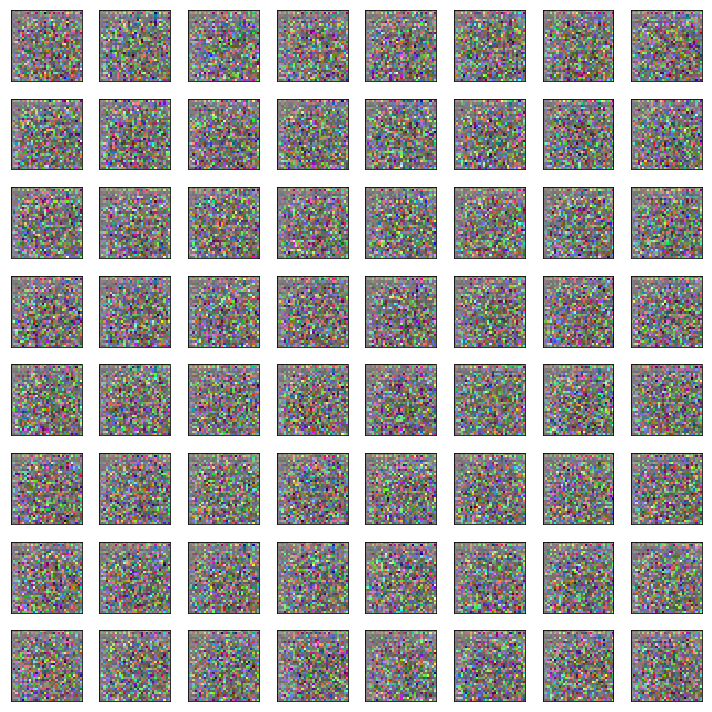

100%|██████████| 1/1 [04:46<00:00, 286.77s/it]


  adding: .config/ (stored 0%)
  adding: .config/.last_update_check.json (deflated 21%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2019.10.22/ (stored 0%)
  adding: .config/logs/2019.10.22/15.18.49.087613.log (deflated 55%)
  adding: .config/logs/2019.10.22/15.18.50.122880.log (deflated 55%)
  adding: .config/logs/2019.10.22/15.18.35.150291.log (deflated 54%)
  adding: .config/logs/2019.10.22/15.18.45.704859.log (deflated 85%)
  adding: .config/logs/2019.10.22/15.18.30.527677.log (deflated 91%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/gce (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (stored 0%)
  adding: .config/.metricsUUID (stored 0%)
  adding: sagan_discriminator.h5 (deflated 8%)
  adding: dcgan_generator.h5 (deflated 8%)
  adding: sagan_generator.h5 (deflated 8%)
  adding: sagan.h5 (def

In [29]:
csagan._fit(1, 64, 0.00005)

## Model Loading

Kindly upload the h5 files, import all the dependencies and run the FID, Spectral and CSGAN classes before loading the models

In [0]:
import keras
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
def one_hot_encode(y):
        z = np.zeros((len(y), 10))
        idx = np.arange(len(y))
        z[idx, y] = 1
        return z

In [0]:
def generate_random_labels(n):
        y = np.random.choice(10, n)
        y = one_hot_encode(y)
        return y

In [6]:
fid = FID()














87916544/87910968 [==============================] - 4s 0us/step


For DCGAN

In [0]:
dcgan_generator = keras.engine.saving.load_model("dcgan_generator.h5")

<Figure size 432x288 with 0 Axes>

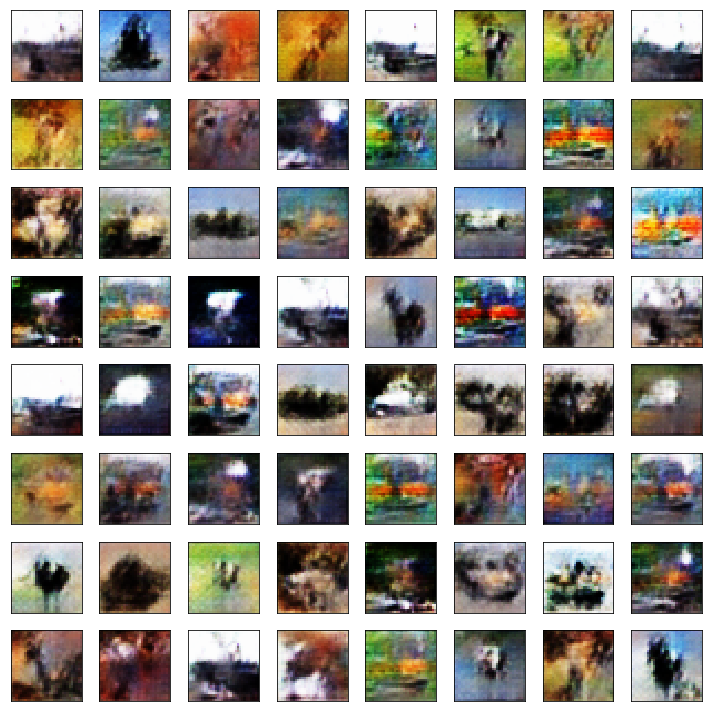

In [13]:
samples = 64
x_fake = dcgan_generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

plt.clf()
f = plt.figure(figsize=(10, 10))
for i in range(samples):
    ax = f.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(((x_fake[i] + 1) * 127).astype(np.uint8))
f.tight_layout()
plt.show()

In [8]:
x_fake = dcgan_generator.predict(np.random.normal(loc=0, scale=1, size=(1000, 100)))
p = np.random.permutation(range(len(x_test)))
score = fid.calculate(x_test[p[:1000]], x_fake, preprocess=True)
print("FID score: " + str(score))

FID score: 621.2444403139368


For SAGAN

In [0]:
csagan = CSAGAN(((x_train, y_train), (x_test, y_test)))

In [12]:
sagan_generator = keras.engine.saving.load_model("sagan_generator.h5", custom_objects={'_conv':csagan._conv, 'tf':tf, '_attention':csagan._attention, '_self_attention':csagan._self_attention})

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<Figure size 432x288 with 0 Axes>

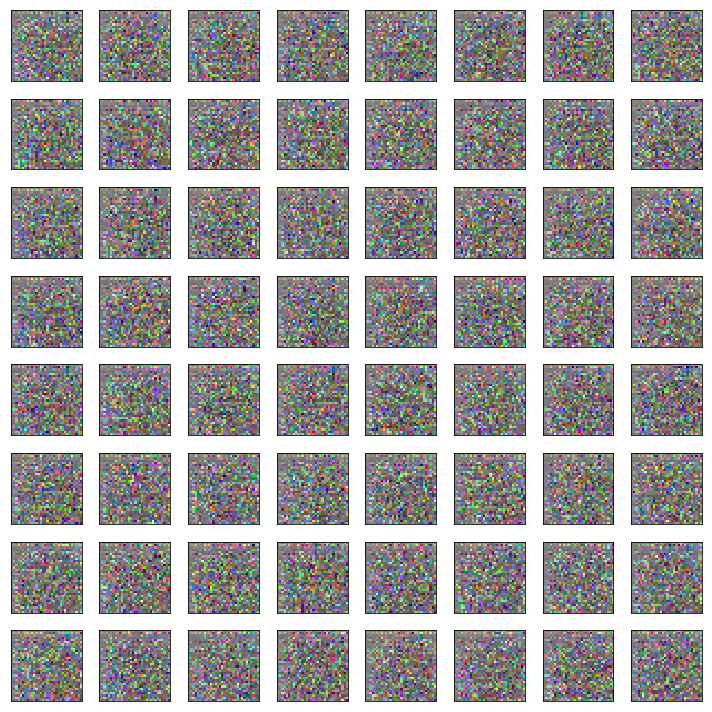

In [15]:
y_train = one_hot_encode(y_train)
samples = 64
p = np.random.permutation(range(len(x_train)))
x_fake = sagan_generator.predict([np.random.normal(loc=0, scale=1, size=(samples, 100)), y_train[p[:samples]]])

plt.clf()
f = plt.figure(figsize=(10, 10))
for i in range(samples):
    ax = f.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(((x_fake[i] + 1) * 127).astype(np.uint8))
f.tight_layout()
plt.show()

In [0]:
p = np.random.permutation(range(len(x_train)))
x_fake = sagan_generator.predict([np.random.normal(loc=0, scale=1, size=(1000, 100)), y_train[p[:1000]]])
p = np.random.permutation(range(len(x_test)))
score = fid.calculate(x_test[p[:1000]], x_fake)
print("FID score: " + str(score))